In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd

## To print everything in a cell, not just the last print statement ##
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv('application_train.csv', header=0)

In [3]:
credit_and_loan_df = pd.DataFrame(data={'loan_paid_status': df['TARGET'], 
                                     'AMT_CREDIT': df['AMT_CREDIT'] })

In [4]:
credit_and_loan_df['AMT_CREDIT_BINNED'] = pd.cut(credit_and_loan_df['AMT_CREDIT'], 
                                         bins = np.linspace(min(credit_and_loan_df['AMT_CREDIT']), 
                                                            max(credit_and_loan_df['AMT_CREDIT']), num = 100),
                                                retbins=False)

In [5]:
credit_and_loan_df

,loan_paid_status,AMT_CREDIT,AMT_CREDIT_BINNED
0,1,406597.5,"(368636.364, 409090.909]"
1,0,1293502.5,"(1258636.364, 1299090.909]"
2,0,135000.0,"(125909.091, 166363.636]"
3,0,312682.5,"(287727.273, 328181.818]"
4,0,513000.0,"(490000.0, 530454.545]"
...,...,...,...
307506,0,254700.0,"(247272.727, 287727.273]"
307507,0,269550.0,"(247272.727, 287727.273]"
307508,0,677664.0,"(651818.182, 692272.727]"
307509,1,370107.0,"(368636.364, 409090.909]"


In [6]:
credit_and_loan_df = credit_and_loan_df.groupby(['AMT_CREDIT_BINNED', 'loan_paid_status']).size().to_frame()
credit_and_loan_df.reset_index(inplace=True)
credit_and_loan_df.set_index('AMT_CREDIT_BINNED', inplace=True)
integer_intervals = list(map(lambda interval: (interval.left,interval.right), credit_and_loan_df.index))
credit_and_loan_df['integer_intervals'] = list(map(lambda interval: str(int(interval[0])) + '-' + str(int(interval[1])), 
                                                   integer_intervals))
credit_and_loan_df.reset_index(inplace=True)
credit_and_loan_df = credit_and_loan_df.drop(['AMT_CREDIT_BINNED'], axis=1)
credit_and_loan_df.set_index('integer_intervals', inplace=True)
credit_and_loan_df = credit_and_loan_df.rename(columns={0: "count"})
credit_and_loan_df

,loan_paid_status,count
integer_intervals,,
45000-85454,0,3384
45000-85454,1,188
85454-125909,0,6162
85454-125909,1,415
125909-166363,0,11738
...,...,...
3564545-3605000,0,2
3847727-3888181,0,1
3928636-3969090,0,1


In [7]:
def f(interval):
    class0, class1 = 0, 0
    sub_df = credit_and_loan_df.loc[interval]
    if np.isscalar(sub_df[sub_df["loan_paid_status"] == 1]):
        class0 = class0 + sub_df[sub_df["loan_paid_status"] == 0]
        class1 = class1 + sub_df[sub_df["loan_paid_status"] == 1]
    else:
        class0 = class0 + int(sub_df[sub_df["loan_paid_status"] == 0]['count'])
        class1 = class1 + int(sub_df[sub_df["loan_paid_status"] == 1]['count'])
    return (class0+class1, class1, interval)

In [8]:
totalCountAndUnpaidCountPerInterval = pd.DataFrame(list(map(f, list(set(credit_and_loan_df.index)))), 
                                                   columns=['Total Loans', 'Unpaid Loans', 'AMT_CREDIT Interval'])
totalCountAndUnpaidCountPerInterval['percentage_unpaid_loans'] = (totalCountAndUnpaidCountPerInterval['Unpaid Loans'] / totalCountAndUnpaidCountPerInterval['Total Loans']) * 100

In [9]:
totalCountAndUnpaidCountPerInterval

,Total Loans,Unpaid Loans,AMT_CREDIT Interval,percentage_unpaid_loans
0,10,1,2593636-2634090,10.000000
1,1087,43,1784545-1825000,3.955842
2,14272,1336,287727-328181,9.360987
3,2,1,2957727-2998181,50.000000
4,2,0,3564545-3605000,0.000000
...,...,...,...,...
72,68,2,2431818-2472272,2.941176
73,244,14,1865454-1905909,5.737705
74,1,0,3928636-3969090,0.000000
75,3456,203,1218181-1258636,5.873843


In [11]:
topLoanIntervalsAsPerCreditAmount = totalCountAndUnpaidCountPerInterval.sort_values('Total Loans',  
                                                                              ascending=False).head(20)

In [12]:
topLoanIntervalsAsPerCreditAmount

,Total Loans,Unpaid Loans,AMT_CREDIT Interval,percentage_unpaid_loans
7,30387,2450,247272-287727,8.062658
61,18347,1778,449545-490000,9.690958
29,16724,1320,166363-206818,7.892849
14,16580,1547,490000-530454,9.330519
22,16197,1244,206818-247272,7.680435
69,15429,1628,530454-570909,10.551559
2,14272,1336,287727-328181,9.360987
44,14156,1047,651818-692272,7.396157
42,12549,811,125909-166363,6.462666
33,11436,1123,328181-368636,9.819867


(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.]),
 <a list of 8 Text xticklabel objects>)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text yticklabel objects>)

Text(0.5, 0, 'xlabel')

Text(0, 0.5, 'ylabel')

[Text(0, 0.5, 'Credit amount interval'), Text(0.5, 0, 'Number of loans')]

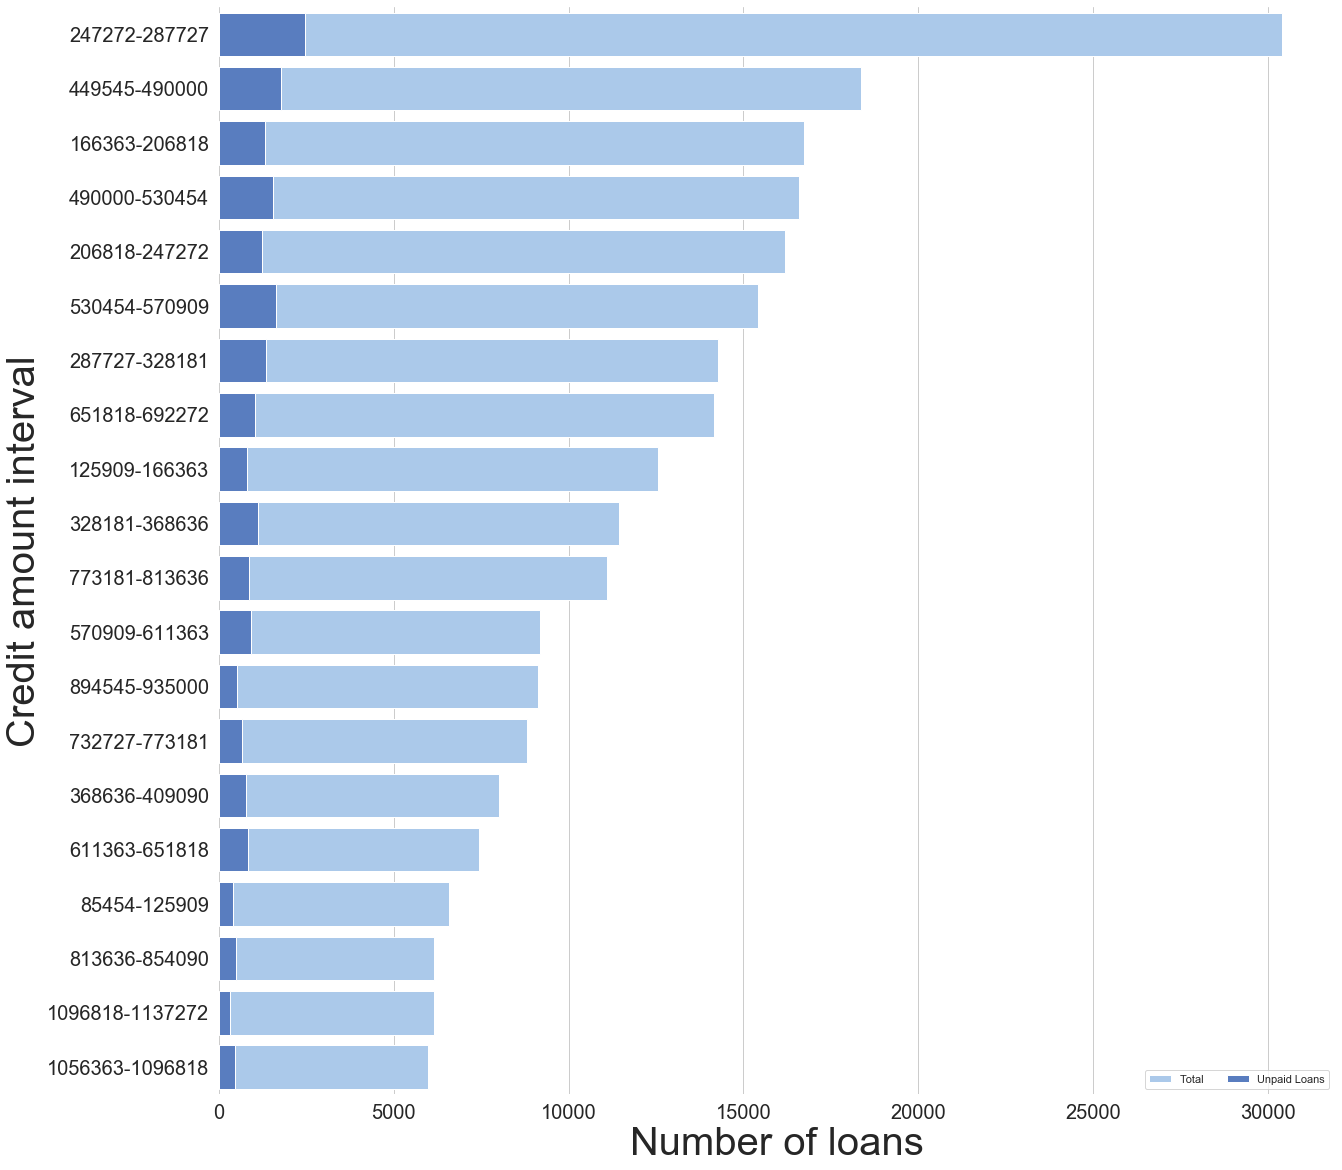

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Load the example car crash dataset
# crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="Total Loans", y="AMT_CREDIT Interval", data=topLoanIntervalsAsPerCreditAmount,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('xlabel', fontsize=40)
plt.ylabel('ylabel', fontsize=40)

sns.barplot(x="Unpaid Loans", y="AMT_CREDIT Interval", data=topLoanIntervalsAsPerCreditAmount,
            label="Unpaid Loans", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Credit amount interval", xlabel="Number of loans")
sns.despine(left=True, bottom=True)

In [14]:
topLoanIntervalsAsPerUnpaidPercentage = totalCountAndUnpaidCountPerInterval.sort_values('percentage_unpaid_loans',  
                                                                              ascending=False).head(20)

In [15]:
topLoanIntervalsAsPerUnpaidPercentage

,Total Loans,Unpaid Loans,AMT_CREDIT Interval,percentage_unpaid_loans
38,2,1,2998181-3038636,50.000000
3,2,1,2957727-2998181,50.000000
70,4,1,2553181-2593636,25.000000
16,5866,729,409090-449545,12.427549
12,7433,841,611363-651818,11.314409
69,15429,1628,530454-570909,10.551559
13,9182,927,570909-611363,10.095840
0,10,1,2593636-2634090,10.000000
76,10,1,4009545-4050000,10.000000
33,11436,1123,328181-368636,9.819867


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

Text(0.5, 0, 'xlabel')

Text(0, 0.5, 'ylabel')

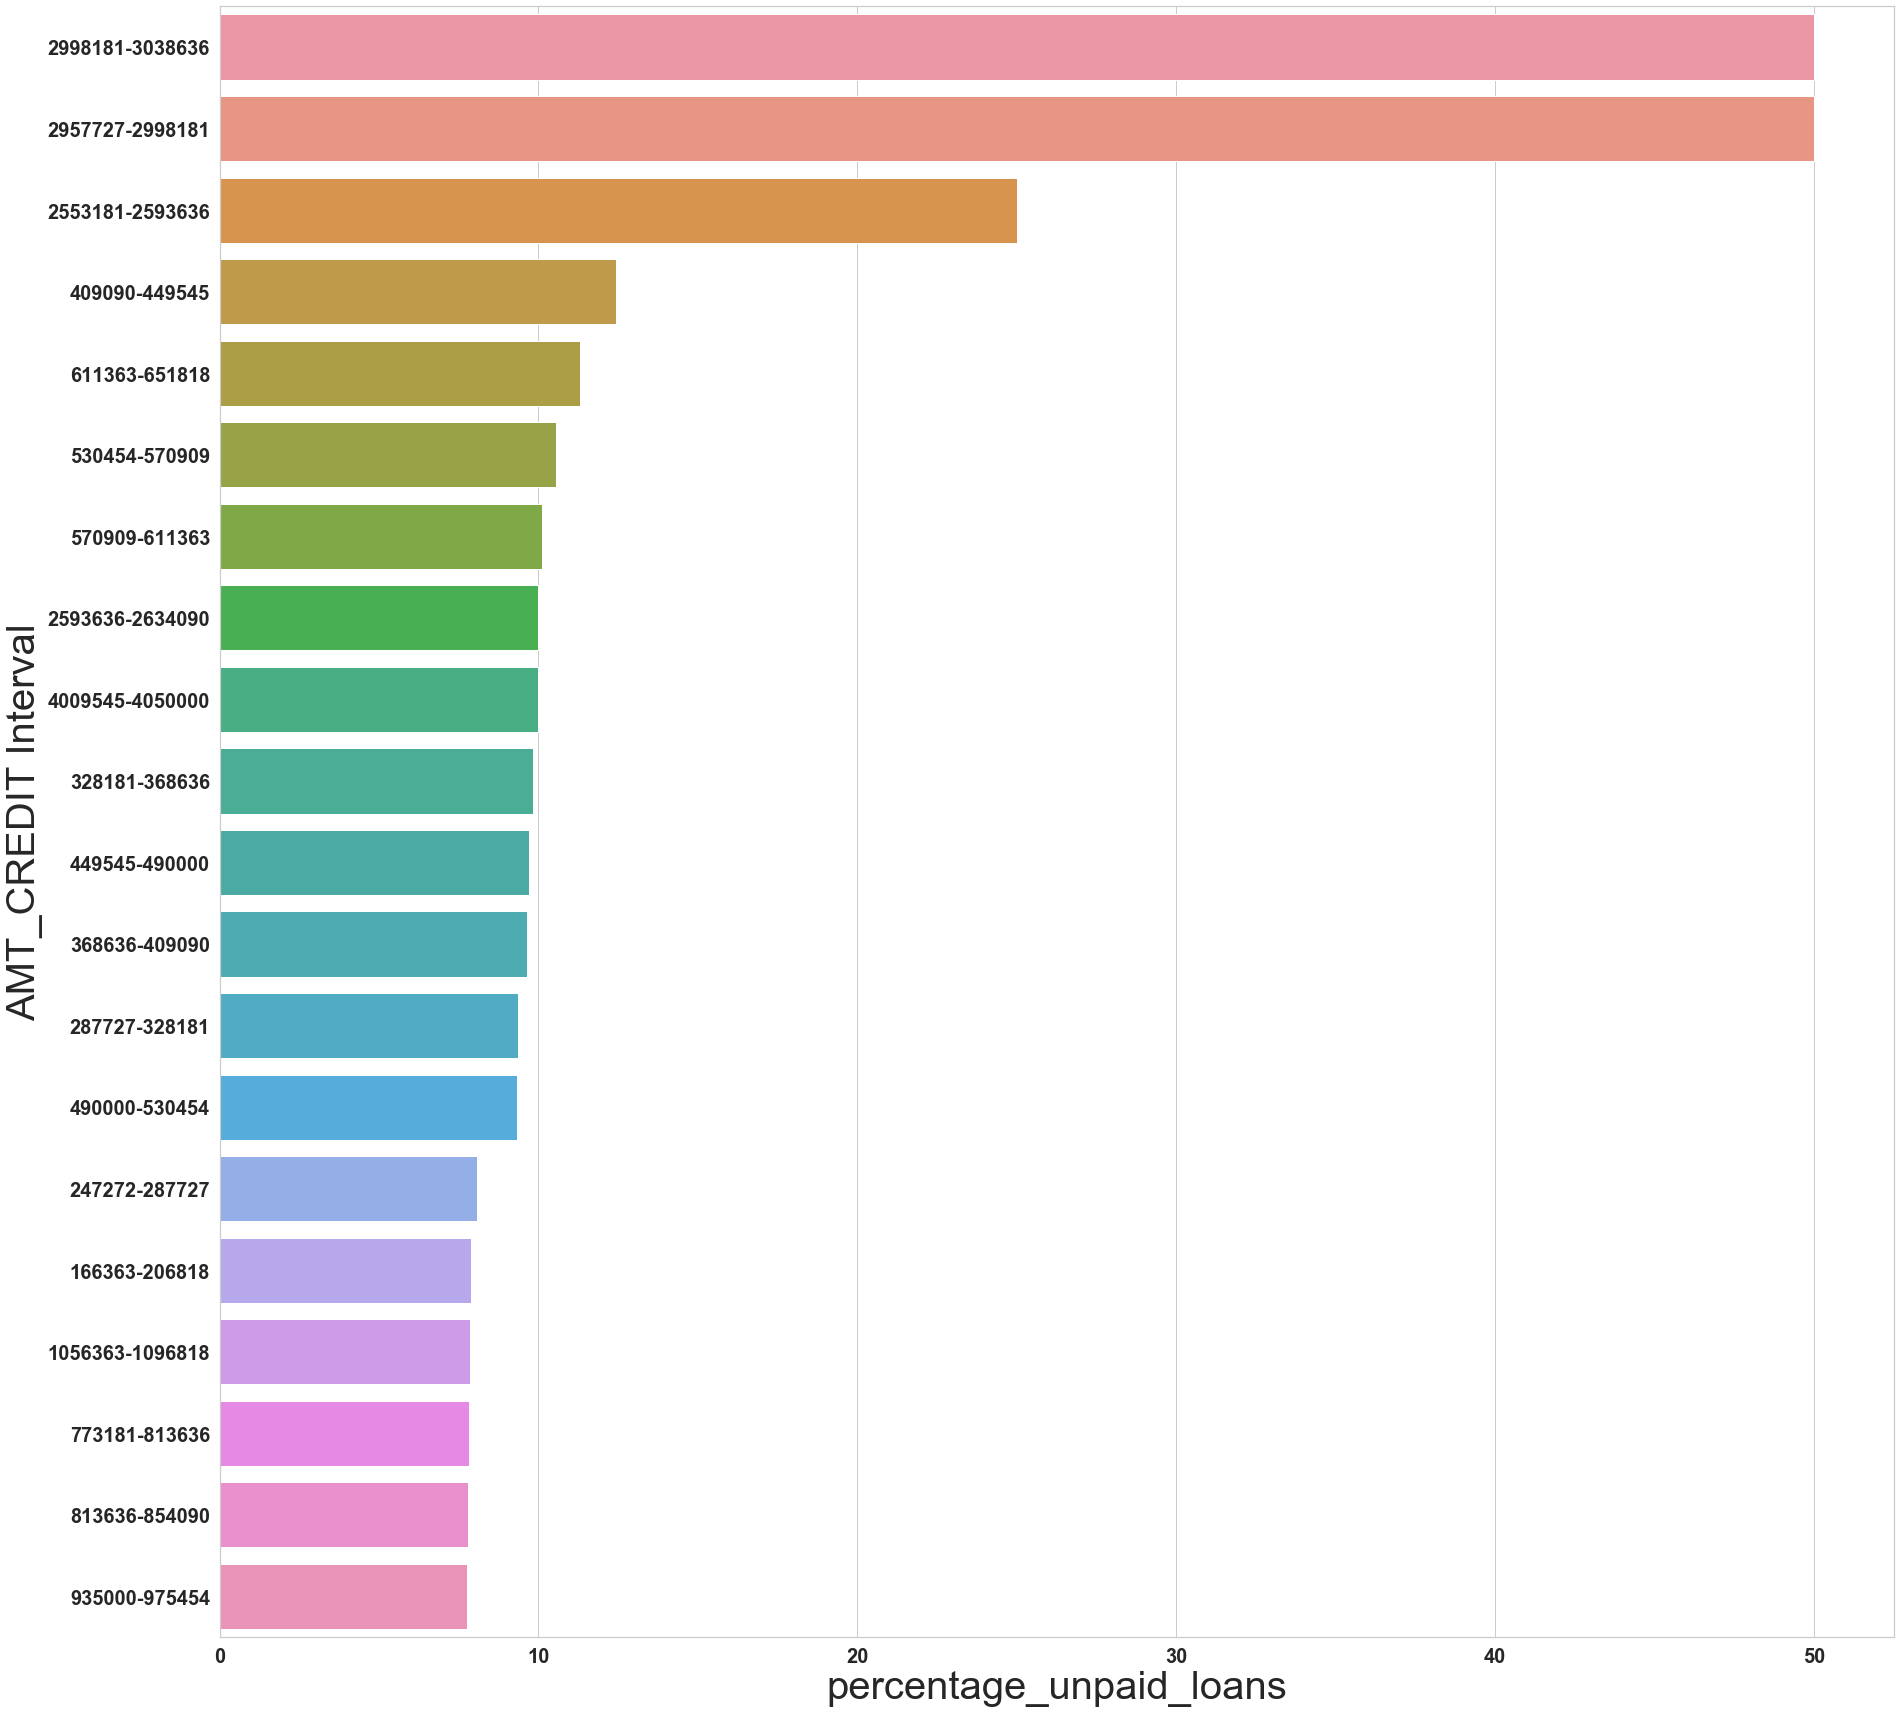

In [16]:
font = {'weight' : 'bold',
        'size'   : 40}

matplotlib.rc('font', **font)
f, axes = plt.subplots(1, 1, figsize=(30, 30))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('xlabel', fontsize=40)
plt.ylabel('ylabel', fontsize=40)
ax = sns.barplot(x="percentage_unpaid_loans", y="AMT_CREDIT Interval", data=topLoanIntervalsAsPerUnpaidPercentage, 
                 ax=axes)